# APPLY KMEANS , AGGLOMERATIVE & DBSCAN CLUSTERING ALGORITHM on Amazon Fine Food Reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Label the review as Positive or negative

 ## Loading,Cleaning & Preprocessing the data

  The dataset is available in two forms
  1. .csv file
  2. SQLite Database

  In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
  <br> 

  Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
con = sqlite3.connect("/content/drive/My Drive/Colab Notebooks/database.sqlite")

filtered_data=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""",con);
filtered_data.head(3)

Id  ...                                               Text
0   1  ...  I have bought several of the Vitality canned d...
1   2  ...  Product arrived labeled as Jumbo Salted Peanut...
2   3  ...  This is a confection that has been around a fe...

[3 rows x 10 columns]

In [4]:
filtered_data.shape

def partition(x):
  if x < 3 :
    return 'negative'
  return 'positive'

actualScore=filtered_data['Score']
positive_negative=actualScore.map(partition)
filtered_data['Score']=positive_negative
print("Number of datapoints",filtered_data.shape)
filtered_data.head(3)

Number of datapoints (525814, 10)


Id  ...                                               Text
0   1  ...  I have bought several of the Vitality canned d...
1   2  ...  Product arrived labeled as Jumbo Salted Peanut...
2   3  ...  This is a confection that has been around a fe...

[3 rows x 10 columns]

In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head(3)

(80668, 7)


UserId  ... COUNT(*)
0  #oc-R115TNMSPFT9I7  ...        2
1  #oc-R11D9D7SHXIJB9  ...        3
2  #oc-R11DNU2NBKQ23Z  ...        2

[3 rows x 7 columns]

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id  ...                                               Text
0   78445  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1  138317  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2  138277  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3   73791  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4  155049  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

[5 rows x 10 columns]

In [8]:
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')

final_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
final_data.shape

(364173, 10)

In [9]:
(final_data['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id  ...                                               Text
0  64422  ...  My son loves spaghetti so I didn't hesitate or...
1  44737  ...  It was almost a 'love at first bite' - the per...

[2 rows x 10 columns]

In [0]:
final_data=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
stopping_words = set(stopwords.words('english'))
print(stopping_words)

{'mightn', 'wouldn', 'i', 'because', 'shan', 'ours', 'few', 'about', "that'll", 'now', 'myself', 'all', 'such', "weren't", 'it', 'further', 'doing', 'ourselves', 'doesn', 'their', 'them', 'between', 'through', 'is', 'most', 'during', 'yourself', 'did', 'just', 'shouldn', 'haven', "wasn't", 'for', 'wasn', 'll', 'down', 'there', 'has', 're', 'we', "isn't", 'aren', 'they', 'didn', 'where', "shan't", 'me', "she's", 'after', 'before', 'above', 'own', 'you', 'yours', 'very', 'can', "doesn't", 'of', 'd', 'hasn', 'hers', 'as', 'any', 'nor', 'so', 'too', 'those', "mightn't", 've', "mustn't", 'themselves', 'don', 'an', 'isn', "couldn't", 'than', 'its', "it's", 'm', 'mustn', 'then', 'couldn', "shouldn't", 'her', 'be', 'yourselves', 'that', 'each', 'am', 'some', 'whom', 'having', 'him', 'ma', 'a', 'how', 'which', "wouldn't", 'himself', "you'll", "didn't", 'with', 'by', 's', 'been', 'needn', 'are', 'have', 'itself', 'both', 'on', 'in', "won't", 'here', 'while', 'out', 'weren', 'other', 'the', 'agai

In [0]:
def clean_html(text):
    clean_r = re.compile('<,*?>')
    clean_text = re.sub(clean_r,'',text)
    return clean_text

def Clean_punc(text):
    clean_sentence = re.sub(r'[?|!|\'|"|#]',r' ',text)
    clean_data = re.sub(r'[.|,|)|(|\|/)]',r' ',clean_sentence)
    return clean_data

In [15]:
from tqdm import tqdm
import os
import pdb
import pickle

from tqdm import tqdm
import os
import pdb
import pickle

stem_no = nltk.stem.SnowballStemmer('english')

if not os.path.isfile('final_data.sqlite'):
    final_string=[]
    all_positive_words=[]
    all_negative_words=[]
    for i,sentence in enumerate(tqdm(final_data['Text'].values)):
        filtered_sentence=[]
        sent_without_html_tags=clean_html(sentence)
        #pdb.set_trace()
        for w in sent_without_html_tags.split():
            for cleaned_words in Clean_punc(w).split():
                if ((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                    if(cleaned_words.lower() not in stopping_words) :
                        stemming=(stem_no.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(stemming)
                        if(final_data['Score'].values)[i]=='positive':
                            all_positive_words.append(stemming)
                        if(final_data['Score'].values)[i]=='negative':
                            all_negative_words.append(stemming)
        str1 = b" ".join(filtered_sentence)
        final_string.append(str1)
        
    final_data['Cleaned_text']=final_string
    final_data['Cleaned_text']=final_data['Cleaned_text'].str.decode("utf-8")    
    
    conn = sqlite3.connect('final_data.sqlite')
    cursor=conn.cursor
    conn.text_factory = str
    final_data.to_sql('Reviews',conn,schema=None,if_exists='replace',index=True,index_label=None,chunksize=None,dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl','wb') as f :
        pickle.dump(all_positive_words,f)
    with open('negative_words.pkl','wb') as f :
        pickle.dump(all_negative_words,f)

100%|██████████| 364171/364171 [06:11<00:00, 980.74it/s]


In [0]:
final_data['total_words'] = [len(x.split()) for x in final_data['Cleaned_text'].tolist()]

In [0]:
final_data.sort_values(by=['Time'], inplace=True, ascending=True)

In [18]:
final_data['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [20]:
final_data=final_data[0:50000]
final_data.head(2)

Id  ... total_words
138706  150524  ...          34
138683  150501  ...          30

[2 rows x 12 columns]

# **KMEAN CLUSTERING ALGORITHM**

# KMEANS ON AMAZON FINE FOOD REVIEW TO FIND THE CLUSTER AND PLOT THE NO OF CLUSTERS WITH INERTIA(INTRA CLUSTER DISTANCE) -----> BAG OF WORDS VECTORIZATION TECHNIQUE

In [0]:
final_data_bow=[]
print(final_data.shape)


print("="*100)

count_vector=CountVectorizer(min_df=100)
final_data_bow=(count_vector.fit_transform(final_data['Cleaned_text'].values))

print("After vectorizations")
print(final_data_bow.shape)

print("="*100)

(50000, 12)
After vectorizations
(50000, 1750)


In [0]:
pd.DataFrame(final_data_bow.toarray(),columns=count_vector.get_feature_names())

abl  absolut  absorb  accept  accord  ...  york  young  yum  yummi  zero
0        1        0       0       0       0  ...     0      0    0      0     0
1        0        0       0       0       0  ...     0      0    0      0     0
2        0        0       0       0       0  ...     0      0    0      0     0
3        0        0       0       0       0  ...     0      0    0      0     0
4        0        0       0       0       0  ...     0      0    0      0     0
...    ...      ...     ...     ...     ...  ...   ...    ...  ...    ...   ...
49995    0        0       0       0       0  ...     0      0    0      0     0
49996    0        0       0       0       0  ...     0      0    0      0     0
49997    0        0       0       0       0  ...     0      0    0      0     0
49998    0        0       0       0       0  ...     0      0    0      0     0
49999    0        0       0       0       0  ...     0      0    0      0     0

[50000 rows x 1750 columns]

#### Apply KMeans to Find the Hyperparameter i.e Best No of Cluster (K)

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans

n_clusters = [1,2,3,4,5,6,7,8,9,10]
plot_inertia=[]
def K_Means_Clustering(x_training_data):  
  for i  in n_clusters:    
    KMeans_Clustering = KMeans(init='k-means++',max_iter=300,n_clusters=i)  
    KMeans_Clustering.fit(x_training_data)
    plot_inertia.append(KMeans_Clustering.inertia_)
  plt.plot(n_clusters, plot_inertia)
  plt.xlabel("Number of Clusters: Hyperparameter")
  plt.ylabel("Inertia(Intra Cluster Distance")
  plt.title("Plot Number of Clusters v/s Inertia(Intra Cluster Distance)")
  plt.grid()
  plt.show()  

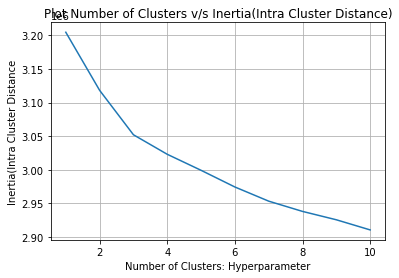

In [0]:
K_Means_Clustering(final_data_bow)

### By looking at the above Plot. Looks like the BEST K is 3. At K=3 , there is an inflexion

In [0]:
from sklearn.cluster import KMeans
K_Mean_Model=KMeans(init='k-means++',max_iter=300,n_clusters=3)
K_Mean_Model.fit(final_data_bow)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### Find the Top 10 Words for each Cluster 

In [0]:
print("Top terms per cluster")
centroids=K_Mean_Model.cluster_centers_.argsort()[:,::-1]

features=count_vector.get_feature_names()
top_words=[]
for i in range(3):  
  top_ten_words = [features[ind] for ind in centroids[i,:10]]  
  top_words.append(top_ten_words)                                             
  print("Clusters {} : {} ".format(i,' '.join(top_ten_words)))    

Top terms per cluster
Clusters 0 : tast great love good like product flavor use one tri 
Clusters 1 : tea flavor green like tast bag drink use make one 
Clusters 2 : like tast flavor one use product good tri food make 


In [0]:
top_words[0]

['tast',
 'great',
 'love',
 'good',
 'like',
 'product',
 'flavor',
 'use',
 'one',
 'tri']

### GENERATE THE TOP 10 WORDS FROM EACH CLUSTER USING WORD CLOUD

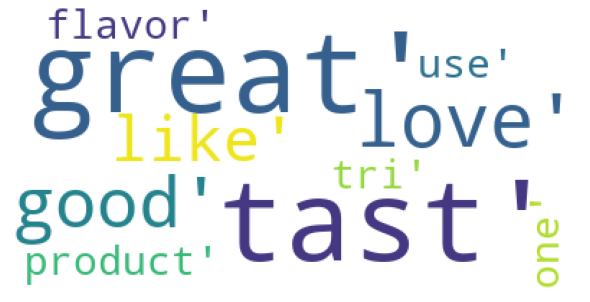

---------------------------------------------------------------------------


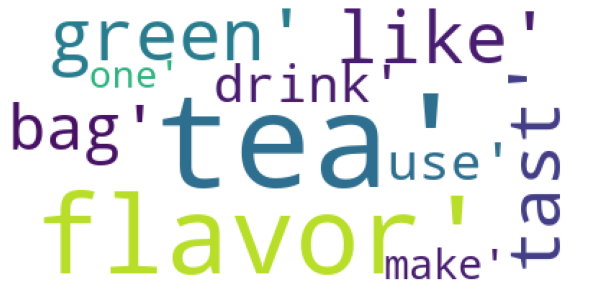

---------------------------------------------------------------------------


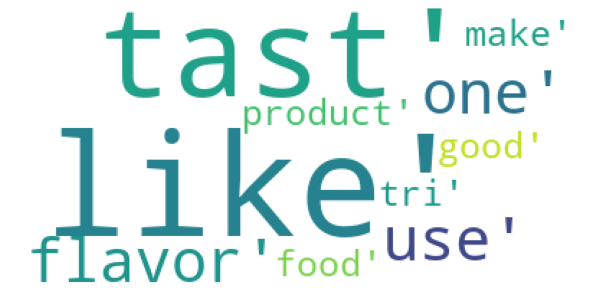

---------------------------------------------------------------------------


In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(3) :
  wordcloud = WordCloud(background_color='white').generate(str(top_words[i]))
  plt.figure(figsize=(8,8),facecolor=None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0) 
  plt.show()
  print('---------------------------------------------------------------------------')

# KMEANS ON AMAZON FINE FOOD REVIEW TO FIND THE CLUSTER AND PLOT THE NO OF CLUSTERS WITH INERTIA(SUM OF ALL INTRA CLUSTER DISTANCE) ----> tf-idf VECTORIZATION TECHNIQUE 

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
final_data_tfidf=[]
print(final_data.shape)


print("="*100)

tfidf_vector=TfidfVectorizer(min_df=100)
final_data_tfidf=(tfidf_vector.fit_transform(final_data['Cleaned_text'].values))

print("After vectorizations")
print(final_data_tfidf.shape)

print("="*100)

(50000, 12)
After vectorizations
(50000, 1750)


In [0]:
pd.DataFrame(final_data_tfidf.toarray(),columns=tfidf_vector.get_feature_names())

abl  absolut  absorb  accept  accord  ...  york  young  yum  yummi  zero
0      0.144869      0.0     0.0     0.0     0.0  ...   0.0    0.0  0.0    0.0   0.0
1      0.000000      0.0     0.0     0.0     0.0  ...   0.0    0.0  0.0    0.0   0.0
2      0.000000      0.0     0.0     0.0     0.0  ...   0.0    0.0  0.0    0.0   0.0
3      0.000000      0.0     0.0     0.0     0.0  ...   0.0    0.0  0.0    0.0   0.0
4      0.000000      0.0     0.0     0.0     0.0  ...   0.0    0.0  0.0    0.0   0.0
...         ...      ...     ...     ...     ...  ...   ...    ...  ...    ...   ...
49995  0.000000      0.0     0.0     0.0     0.0  ...   0.0    0.0  0.0    0.0   0.0
49996  0.000000      0.0     0.0     0.0     0.0  ...   0.0    0.0  0.0    0.0   0.0
49997  0.000000      0.0     0.0     0.0     0.0  ...   0.0    0.0  0.0    0.0   0.0
49998  0.000000      0.0     0.0     0.0     0.0  ...   0.0    0.0  0.0    0.0   0.0
49999  0.000000      0.0     0.0     0.0     0.0  ...   0.0    0.0  0.0    0.0   0.0

[50000 rows x 1750 columns]

### Apply KMeans to find the Hyperparameter i.e Best No of Cluster(K)

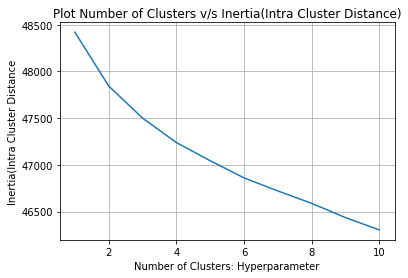

In [0]:
K_Means_Clustering(final_data_tfidf)

### BY LOOKING AT THE ABOVE PLOT , LOOKS IKE THE BEST K IS 5.

In [0]:
from sklearn.cluster import KMeans
K_Mean_Model=KMeans(init='k-means++',max_iter=300,n_clusters=5)
K_Mean_Model.fit(final_data_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### FIND TOP 10 WORDS FOR EACH CLUSTER 

In [0]:
print("Top terms per cluster")
centroids=K_Mean_Model.cluster_centers_.argsort()[:,::-1]

features=tfidf_vector.get_feature_names()
top_words=[]
for i in range(5):  
  top_ten_words = [features[ind] for ind in centroids[i,:10]]  
  top_words.append(top_ten_words)                                             
  print("Clusters {} : {} ".format(i,' '.join(top_ten_words)))   

Top terms per cluster
Clusters 0 : tast like good flavor great love use tri one make 
Clusters 1 : product order amazon store price find ship great buy love 
Clusters 2 : tea green flavor drink tast like bag cup love good 
Clusters 3 : coffe cup flavor pod tast like roast strong good tri 
Clusters 4 : dog cat treat food love chew one eat like get 


### GENERATE THE TOP 10 WORDS FROM EACH CLUSTER USING WORD CLOUD

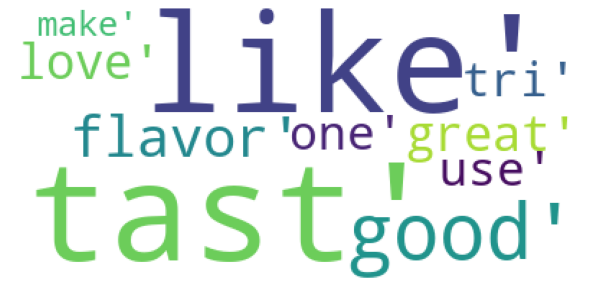

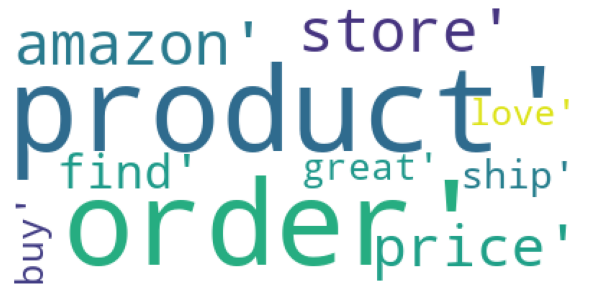

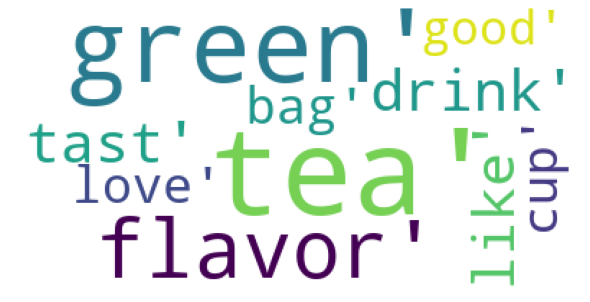

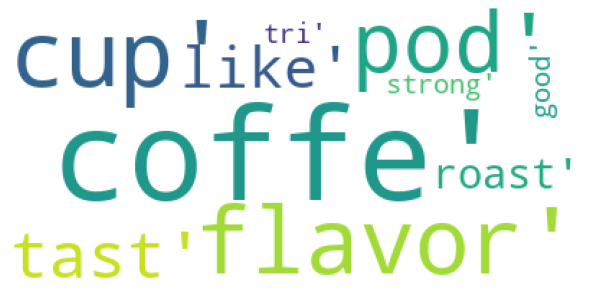

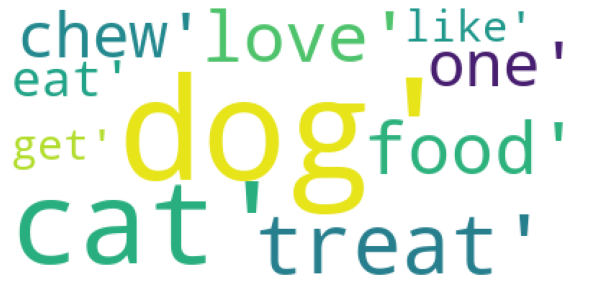

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(5) :
  wordcloud = WordCloud(background_color='white').generate(str(top_words[i]))
  print("="*100)
  plt.figure(figsize=(8,8),facecolor=None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0) 
  plt.show()
  print("="*100)

# KMEANS ON AMAZON FINE FOOD REVIEW TO FIND THE CLUSTER AND PLOT THE NO OF CLUSTERS WITH INERTIA(SUM OF ALL INTRA CLUSTER DISTANCE) --> AVG WORD2VEC

In [0]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

list_of_sent_train_avgw2v=[]

for sent_train_avgw2v in tqdm(final_data['Cleaned_text'].values):
    list_of_sent_train_avgw2v.append(sent_train_avgw2v.split())

100%|██████████| 50000/50000 [00:00<00:00, 83276.96it/s]


In [0]:
w2v_model_train = Word2Vec(list_of_sent_train_avgw2v,min_count=5,size=50,workers=4)
w2v_words_svm_train=list(w2v_model_train.wv.vocab)

In [0]:
train_vectors=[];
for sent in tqdm(list_of_sent_train_avgw2v):
    sent_vec=np.zeros(50)
    cnt_words=0;
    for word in sent:
        if word in w2v_words_svm_train:
            vec=w2v_model_train.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words !=0:
        sent_vec/=cnt_words
    train_vectors.append(sent_vec)
print(len(train_vectors))
print(len(train_vectors[0]))

100%|██████████| 50000/50000 [00:54<00:00, 911.49it/s]

50000
50


### Apply KMeans to find the Hyperparameter i.e Best No of Clusters(K)

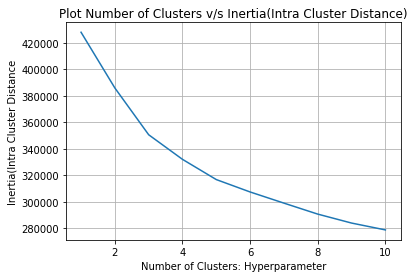

In [0]:
K_Means_Clustering(train_vectors)

### By Looking at the Plot. Looks like No Of Cluster is 5 i.e K=5

In [0]:
K_Mean_Model=KMeans(init='k-means++',max_iter=300,n_clusters=5)
predict_cluster_index=K_Mean_Model.fit_predict(train_vectors)

In [0]:
cluster_index =[]

for i in range(len(predict_cluster_index)):
  if predict_cluster_index[i] == 2:
    cluster_index.append(i)

In [0]:
text_features=[]

for i in range(len(cluster_index)) :
  text_features.append(list_of_sent_train_avgw2v[cluster_index[i]])

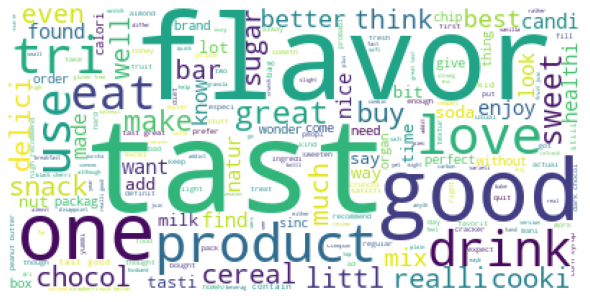

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

text_var = ''
for j in range(len(text_features)):
    for i in range(len(text_features[j])):
        text_var = text_var + text_features[j][i] + ' '
wordcloud = WordCloud(background_color='white').generate(str(text_var))
print("="*100)
plt.figure(figsize=(8,8),facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()
print("="*100)

# KMEANS ON AMAZON FINE FOOD REVIEW TO FIND THE CLUSTER AND PLOT THE NO OF CLUSTERS WITH INERTIA(SUM OF ALL INTRA CLUSTER DISTANCE) ----> TF-IDF WORD 2VEC VECTORIZATION TECHNIQUE 

In [0]:
model_Avgw2v = TfidfVectorizer()
X_Train_Avgw2v=model_Avgw2v.fit_transform(final_data['Cleaned_text'].values)

In [0]:
dictionary = dict(zip(model_Avgw2v.get_feature_names(), list(model_Avgw2v.idf_)))

In [0]:
tfidf_feature=model_Avgw2v.get_feature_names()

tfidf_sent_vectors_train=[];
row=0;

for sent in tqdm(list_of_sent_train_avgw2v):
    sent_vec=np.zeros(50)
    weight_sum=0;
    for word in sent :
        if word in w2v_words_svm_train and word in tfidf_feature :
            vec=w2v_model_train.wv[word]            
            tf_idf=dictionary[word]*(sent.count(word)/len(sent))
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
    
    if weight_sum!=0:
        sent_vec/=weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row+=1

100%|██████████| 50000/50000 [10:50<00:00, 76.90it/s]


### Apply KMeans to find the Best Hyperparameter i.e Best No of Clusters K

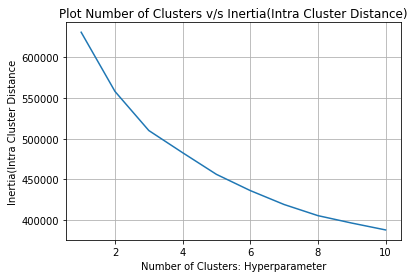

In [0]:
K_Means_Clustering(tfidf_sent_vectors_train)

### By looking at the plot. It looks like the Best K will be 3 i.e K=3 
### No of Clusters = 3

In [0]:
K_Mean_Model=KMeans(init='k-means++',max_iter=300,n_clusters=3)
fit_model=K_Mean_Model.fit(tfidf_sent_vectors_train)

In [0]:
print("Top terms per cluster")
centroids=fit_model.cluster_centers_.argsort()[:,::-1]

tfidf_feature=model_Avgw2v.get_feature_names()

top_words=[]
for i in range(3):  
  top_ten_words = [tfidf_feature[ind] for ind in centroids[i,:10]]  
  top_words.append(top_ten_words)                                             
  print("Clusters {} : {} ".format(i,' '.join(top_ten_words)))  

Top terms per cluster
Clusters 0 : aberr aad aafco abound aboth aback abigirl abc abour aand 
Clusters 1 : abigirl aaaaah aand aberr aad aboth abondanza abour abound aback 
Clusters 2 : aboard aah abj aardvark abi abigirl aaa aad aand aberr 


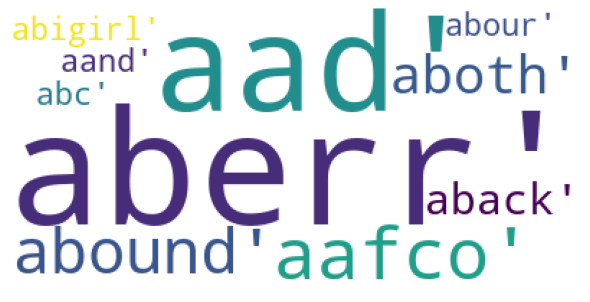

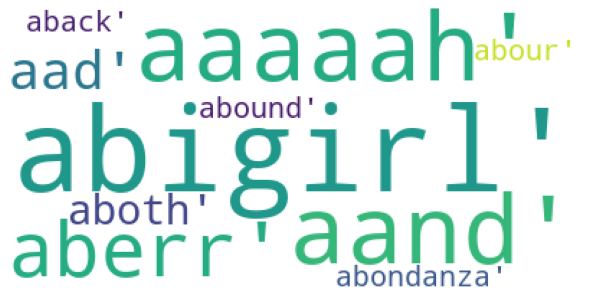

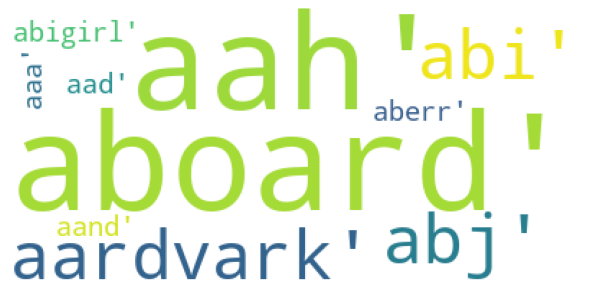

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(3) :
  wordcloud = WordCloud(background_color='white').generate(str(top_words[i]))
  print("="*100)
  plt.figure(figsize=(8,8),facecolor=None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0) 
  plt.show()
  print("="*100)

# **AGGLOMERATIVE CLUSTERING ALGORITHM**

## USING AVGWORD2VEC FEATURIZATION TECHNIQUE

In [0]:
final_data_new=final_data[:5000]

In [0]:
final_data_new=final_data_new['Cleaned_text']

In [0]:
final_data_new_array=final_data_new.to_numpy()

In [25]:
final_data_new_array[66]

'tim burton start take serious michael keaton unleash unus restrain alec baldwin support cast known looni danc puppetmast burton tune'

In [26]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

list_of_sent_avgw2v_agglo=[]

for sent_train_avgw2v in tqdm(final_data_new):
    list_of_sent_avgw2v_agglo.append(sent_train_avgw2v.split())

100%|██████████| 5000/5000 [00:00<00:00, 134248.66it/s]


In [0]:
w2v_model_train = Word2Vec(list_of_sent_avgw2v_agglo,min_count=5,size=50,workers=4)
w2v_words_svm_train=list(w2v_model_train.wv.vocab)

In [28]:
train_vectors=[];
for sent in tqdm(list_of_sent_avgw2v_agglo):
    sent_vec=np.zeros(50)
    cnt_words=0;
    for word in sent:
        if word in w2v_words_svm_train:
            vec=w2v_model_train.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words !=0:
        sent_vec/=cnt_words
    train_vectors.append(sent_vec)
print(len(train_vectors))
print(len(train_vectors[0]))

100%|██████████| 5000/5000 [00:05<00:00, 999.47it/s] 

5000
50


### APPLY AGGLOMERATIVE CLUSTERING TO FIND THE BEST HYPERPARAMETER I.E BEST NO OF CLUSTERS 

# For K = 2

In [0]:
from sklearn.cluster import AgglomerativeClustering

k = 2
cluster_label=[]
Agglo_Clustering = AgglomerativeClustering(n_clusters=k)  
cluster_label=Agglo_Clustering.fit_predict(train_vectors)

In [0]:
C1,C2 =[],[]

for i in range(Agglo_Clustering.labels_.shape[0]):
  if Agglo_Clustering.labels_[i]==0 : 
    C1.append(final_data_new_array[i])
  else:
    C2.append(final_data_new_array[i])

### CLUSTER 1 FEATURES

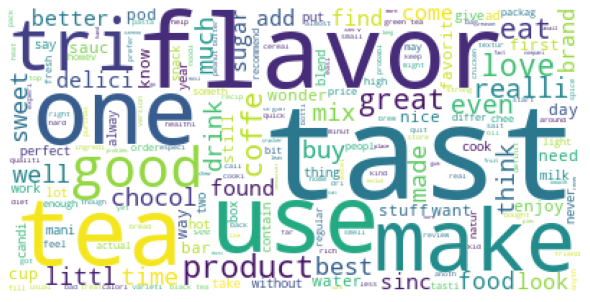

In [0]:
display_data=''

for i in C1:
  display_data+=str(i)

from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color='white').generate(display_data)
print("="*100)
plt.figure(figsize=(8,8),facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()
print("="*100)  

### CLUSTER 2 FEATURES

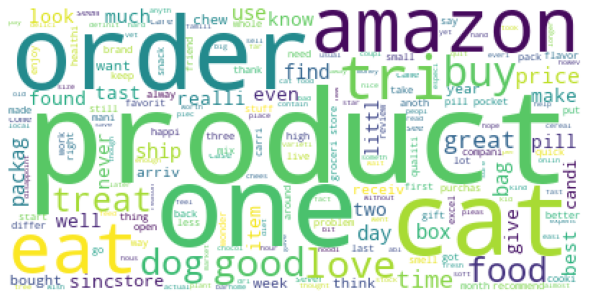

In [0]:
display_data_C2=''

for i in C2:
  display_data_C2+=str(i)
wordcloud = WordCloud(background_color='white').generate(display_data_C2)
print("="*100)
plt.figure(figsize=(8,8),facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()
print("="*100) 

# For K=5

In [0]:
from sklearn.cluster import AgglomerativeClustering
k = 5
cluster_label=[]
Agglo_Clustering = AgglomerativeClustering(n_clusters=k)  
cluster_label=Agglo_Clustering.fit_predict(train_vectors)

In [0]:
def display_data_agglo(cluster):
  display_data=''
  for i in cluster:
    display_data+=str(i)
  wordcloud = WordCloud(background_color='white').generate(display_data)
  print("="*100)
  plt.figure(figsize=(8,8),facecolor=None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0) 
  plt.show()
  print("="*100) 

In [0]:
C1,C2,C3,C4,C5 =[],[],[],[],[]

for i in range(Agglo_Clustering.labels_.shape[0]):
  if Agglo_Clustering.labels_[i]==0 : 
    C1.append(final_data_new_array[i])    
  elif Agglo_Clustering.labels_[i]==1 :
    C2.append(final_data_new_array[i])    
  elif Agglo_Clustering.labels_[i]==2 :
    C3.append(final_data_new_array[i])    
  elif Agglo_Clustering.labels_[i]==3 :
    C4.append(final_data_new_array[i])
  else:
    C5.append(final_data_new_array[i])    

### CLUSTER 1 FEATURES

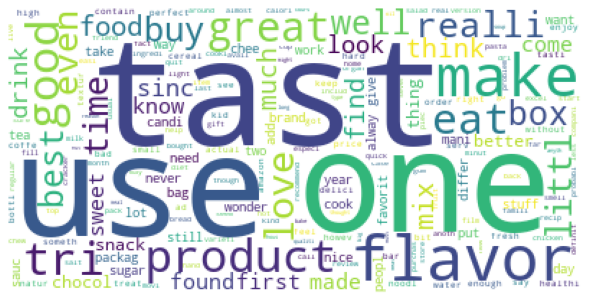

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
display_data_agglo(C1)

### CLUSTER 2 FEATURES

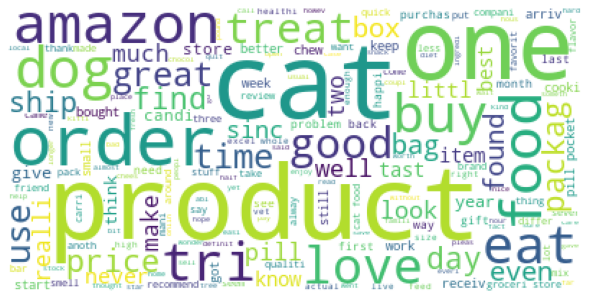

In [34]:
display_data_agglo(C2)

### CLUSTER 3 FEATURES

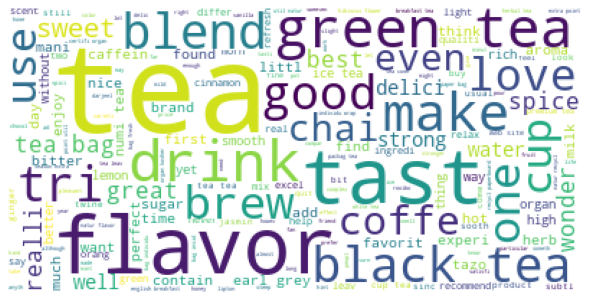

In [35]:
display_data_agglo(C3)

### CLUSTER 4 FEATURES

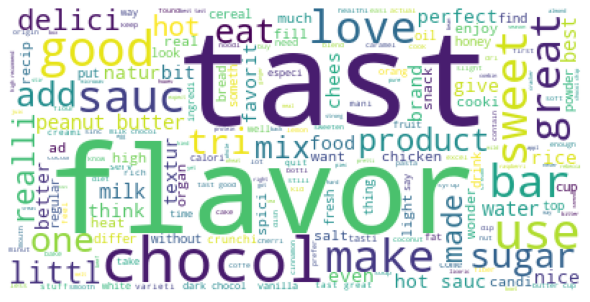

In [36]:
display_data_agglo(C4)

### CLUSTER 5 FEATURES

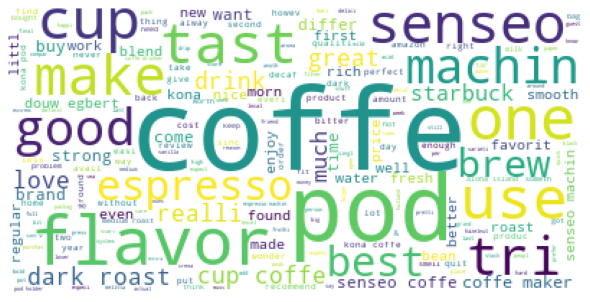

In [37]:
display_data_agglo(C5)

## USING TF-IDF WORD2VEC FEATURIZATION TECHNIQUE 

In [0]:
model_Avgw2v = TfidfVectorizer()
X_Train_Avgw2v=model_Avgw2v.fit_transform(final_data_new)

In [0]:
dictionary = dict(zip(model_Avgw2v.get_feature_names(), list(model_Avgw2v.idf_)))

In [38]:
tfidf_feature=model_Avgw2v.get_feature_names()

tfidf_sent_vectors_train=[];
row=0;

for sent in tqdm(list_of_sent_avgw2v_agglo):
    sent_vec=np.zeros(50)
    weight_sum=0;
    for word in sent :
        if word in w2v_words_svm_train and word in tfidf_feature :
            vec=w2v_model_train.wv[word]            
            tf_idf=dictionary[word]*(sent.count(word)/len(sent))
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
    
    if weight_sum!=0:
        sent_vec/=weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row+=1

100%|██████████| 5000/5000 [00:33<00:00, 150.70it/s]


In [0]:
k = 2
cluster_label=[]
Agglo_Clustering = AgglomerativeClustering(n_clusters=k)  
cluster_label=Agglo_Clustering.fit_predict(tfidf_sent_vectors_train)

In [0]:
C1,C2 =[],[]

for i in range(Agglo_Clustering.labels_.shape[0]):
  if Agglo_Clustering.labels_[i]==0 : 
    C1.append(final_data_new_array[i])
  else:
    C2.append(final_data_new_array[i])

## CLUSTER 1 FEATURES

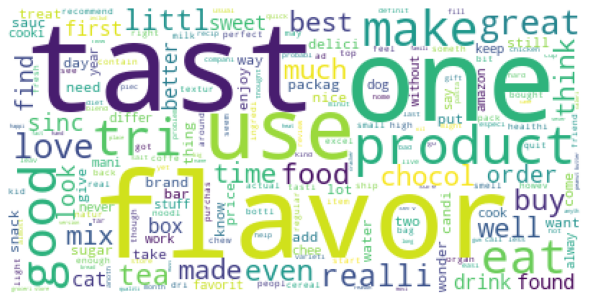

In [43]:
display_data_agglo(C1)

## CLUSTER 2 FEATURES

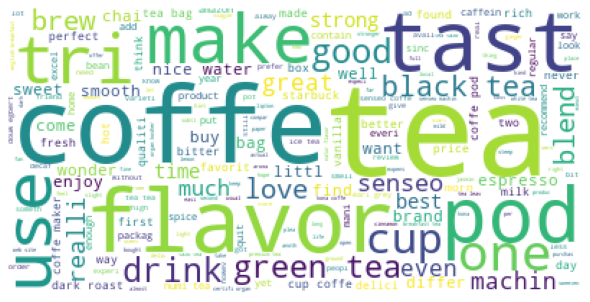

In [44]:
display_data_agglo(C2)

In [0]:
k = 5
cluster_label=[]
Agglo_Clustering = AgglomerativeClustering(n_clusters=k)  
cluster_label=Agglo_Clustering.fit_predict(tfidf_sent_vectors_train)

In [0]:
C1,C2,C3,C4,C5 =[],[],[],[],[]

for i in range(Agglo_Clustering.labels_.shape[0]):
  if Agglo_Clustering.labels_[i]==0 : 
    C1.append(final_data_new_array[i])    
  elif Agglo_Clustering.labels_[i]==1 :
    C2.append(final_data_new_array[i])    
  elif Agglo_Clustering.labels_[i]==2 :
    C3.append(final_data_new_array[i])    
  elif Agglo_Clustering.labels_[i]==3 :
    C4.append(final_data_new_array[i])
  else:
    C5.append(final_data_new_array[i])

## CLUSTER 1 FEATURES 

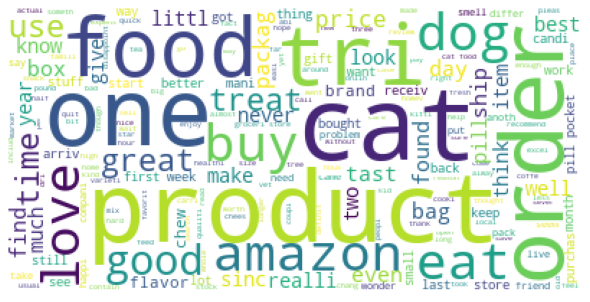

In [48]:
display_data_agglo(C1)

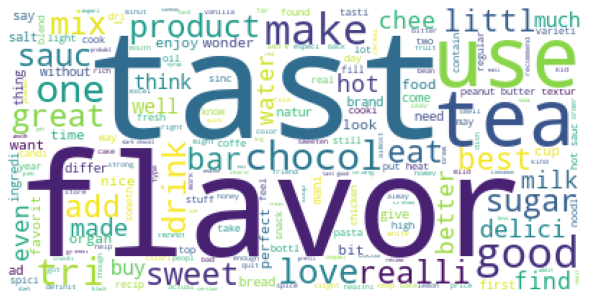

In [49]:
display_data_agglo(C2)

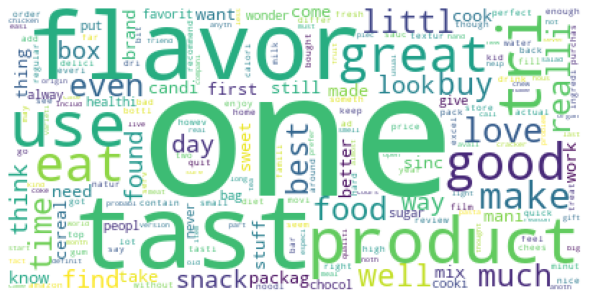

In [50]:
display_data_agglo(C3)

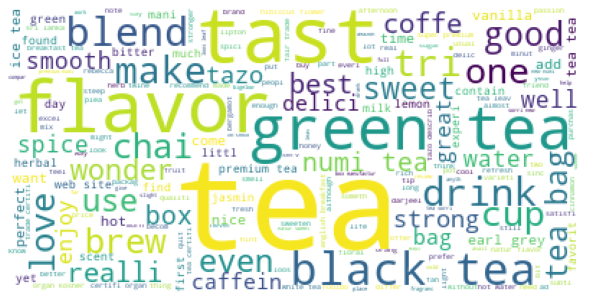

In [51]:
display_data_agglo(C4)

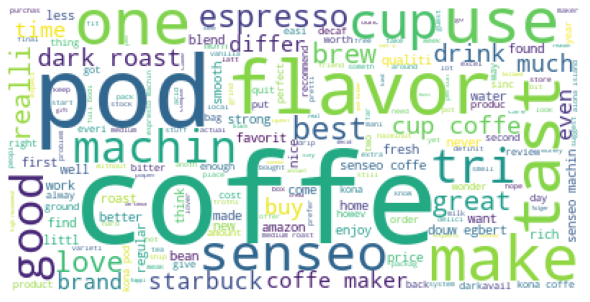

In [52]:
display_data_agglo(C5)

# DBSCAN CLUSTERING ALGORITHM

### USING AVGWORD2VEC FEATURIZATION TECHNIQUE APPLY DBSCAN CLUSTERING TECHNIQUE TO FINE THE BEST HYPERPARAMETER 

In [31]:
from sklearn.cluster import DBSCAN


cluster_label=[]
dbscan_Clustering = DBSCAN(eps=0.5,n_jobs=-1,algorithm='kd_tree')
dbscan_Clustering.fit(train_vectors)
print('No Of Clusters' ,len(set(dbscan_Clustering.labels_)))

No Of Clusters 2


### No of Cluster for eps = 0.5 is 2 

In [32]:
print('Cluster are ignored',set(dbscan_Clustering.labels_))

Cluster are ignored {0, -1}


In [0]:
C1,C2 =[],[]

for i in range(dbscan_Clustering.labels_.shape[0]):
  if dbscan_Clustering.labels_[i]==0 : 
    C1.append(final_data_new_array[i])
  else:
    C2.append(final_data_new_array[i])

# For K=2

### CLUSTER 1 FEATURES

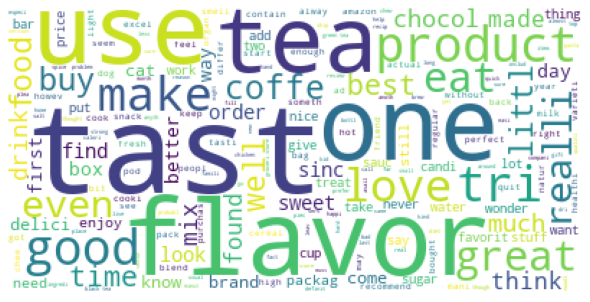

In [34]:
display_data=''

for i in C1:
  display_data+=str(i)

from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color='white').generate(display_data)
print("="*100)
plt.figure(figsize=(8,8),facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()
print("="*100) 

### CLUSTER 2 FEATURES 

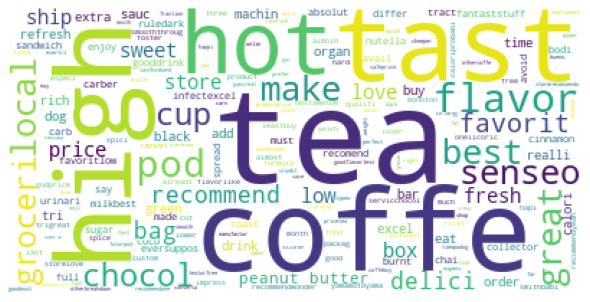

In [35]:
display_data=''

for i in C2:
  display_data+=str(i)

from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color='white').generate(display_data)
print("="*100)
plt.figure(figsize=(8,8),facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()
print("="*100) 

### USING TF-IDF FEATURIZATION TECHNIQUE APPLY DBSCAN CLUSTERING TECHNIQUE TO FIND THE BEST HYPERPARAMETER

In [41]:
dbscan_Clustering = DBSCAN(eps=0.1,n_jobs=-1,algorithm='kd_tree')
dbscan_Clustering.fit(tfidf_sent_vectors_train)
print('No Of Clusters' ,len(set(dbscan_Clustering.labels_)))

No Of Clusters 10


In [42]:
dbscan_Clustering = DBSCAN(eps=0.5,n_jobs=-1,algorithm='kd_tree')
dbscan_Clustering.fit(tfidf_sent_vectors_train)
print('No Of Clusters' ,len(set(dbscan_Clustering.labels_)))

No Of Clusters 2


In [43]:
dbscan_Clustering = DBSCAN(eps=1,n_jobs=-1,algorithm='kd_tree')
dbscan_Clustering.fit(tfidf_sent_vectors_train)
print('No Of Clusters' ,len(set(dbscan_Clustering.labels_)))

No Of Clusters 2


In [0]:
C1,C2 =[],[]

for i in range(dbscan_Clustering.labels_.shape[0]):
  if dbscan_Clustering.labels_[i]==0 : 
    C1.append(final_data_new_array[i])
  else:
    C2.append(final_data_new_array[i])

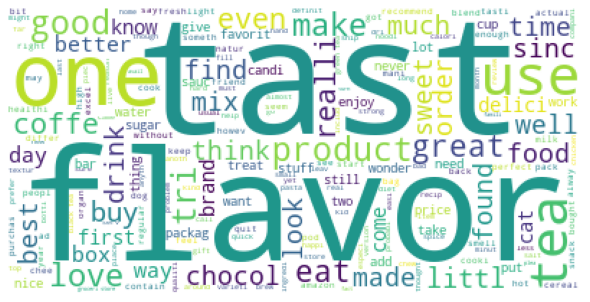

In [45]:
display_data=''

for i in C1:
  display_data+=str(i)

from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color='white').generate(display_data)
print("="*100)
plt.figure(figsize=(8,8),facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()
print("="*100) 

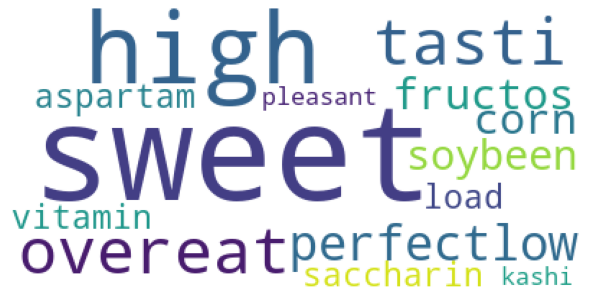

In [46]:
display_data=''

for i in C2:
  display_data+=str(i)

from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color='white').generate(display_data)
print("="*100)
plt.figure(figsize=(8,8),facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()
print("="*100) 

In [48]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Clustering Algorithm Technique","Vectorizer","Best k"]
x.add_row(['KMeans','BOW','3'])
x.add_row(['KMeans','TFIDF','5'])
x.add_row(['KMeans','AVG W2vec','5'])
x.add_row(['KMeans','TFIDF W2vec','3'])
x.add_row(['AGGLOMERATIVE','AVGWORD2VEC','(2,5)'])
x.add_row(['AGGLOMERATIVE','TFIDFW2vec','(2,5)'])
x.add_row(['DBSCAN','AVGW2vec(eps =0.5)','2'])
x.add_row(['DBSCAN','TFIDFW2vec(eps=0.1)','10'])
x.add_row(['DBSCAN','TFIDFW2vec(eps=0.5)','2'])
x.add_row(['DBSCAN','TFIDFW2vec(eps=1)','2'])
print(x)

+--------------------------------+---------------------+--------+
| Clustering Algorithm Technique |      Vectorizer     | Best k |
+--------------------------------+---------------------+--------+
|             KMeans             |         BOW         |   3    |
|             KMeans             |        TFIDF        |   5    |
|             KMeans             |      AVG W2vec      |   5    |
|             KMeans             |     TFIDF W2vec     |   3    |
|         AGGLOMERATIVE          |     AVGWORD2VEC     | (2,5)  |
|         AGGLOMERATIVE          |      TFIDFW2vec     | (2,5)  |
|             DBSCAN             |  AVGW2vec(eps =0.5) |   2    |
|             DBSCAN             | TFIDFW2vec(eps=0.1) |   10   |
|             DBSCAN             | TFIDFW2vec(eps=0.5) |   2    |
|             DBSCAN             |  TFIDFW2vec(eps=1)  |   2    |
+--------------------------------+---------------------+--------+
